# Reparametrization of Curves 

In [1]:
# Remove from public version
%load_ext autoreload
%autoreload 2

## 1. Default Reparametrization (Immersion, Infinity)

In [24]:
from pathlib import Path

import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


from funcshape.networks import CurveReparametrizer
from funcshape.layers.sineseries import SineSeries
from funcshape.loss import CurveDistance
from funcshape.logging import Logger
from funcshape.testlib.curves import Infinity, LogStepDiff
from funcshape.transforms import Qmap1D
from funcshape.reparametrize import reparametrize
from funcshape.utils import col_linspace
from funcshape.visual import plot_curve

### Display Figures Before Reparametrization

In [27]:
figpath=Path("../figures/")
def savefig(name, fig=None):
    path = figpath / name
    path.parent.mkdir(exist_ok=True)
    if fig is None:
        plt.savefig(figpath / name, bbox_inches="tight")
    else:
        fig.savefig(figpath / name, bbox_inches="tight")

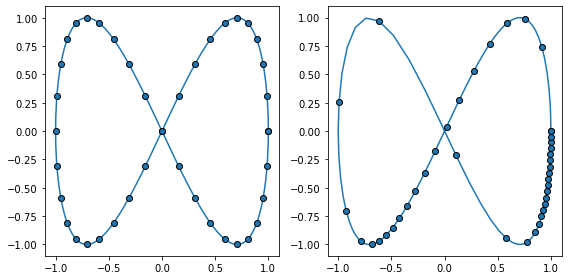

In [28]:
# Analytic diffeomorphism
g = LogStepDiff()

# Define Curves 
c1 = Infinity()
c2 = c1.compose(g)

# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
q, r = Qmap1D(c2), Qmap1D(c1)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_curve(c1, dotpoints=41, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, dotpoints=41, ax=plt.gca())
plt.tight_layout()
plt.show()


Finished training in 0.99175s


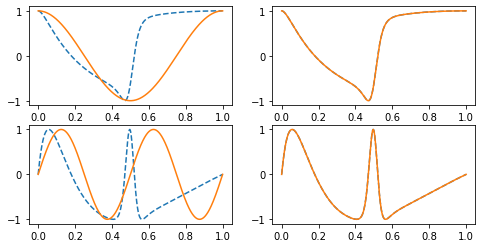

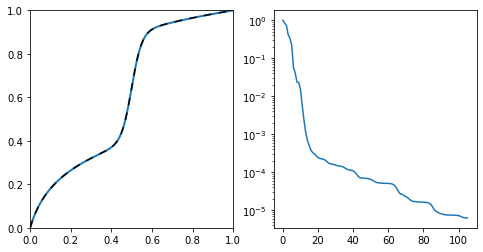

In [4]:
# Create reparametrization network
RN = CurveReparametrizer([
    SineSeries(10) for i in range(10)
])

# Define loss, optimizer and run reparametrization.
loss_func = CurveDistance(q, r, k=1024)
optimizer = optim.LBFGS(RN.parameters(), lr=1., max_iter=200, line_search_fn='strong_wolfe')
error = reparametrize(RN, loss_func, optimizer, 200, Logger(0))

# Get plot data to visualize diffeomorphism
RN.detach()
x = col_linspace(0, 1, 1024)
y = RN(x)

# Get curve-coordinates before and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(y)

# Plot coordinates before reparametrization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 4))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])
ax3.plot(x, C2[:, 1], ls="dashed")
ax3.plot(x, C1[:, 1])

# Plot coordinates after reparametrization
ax2.plot(x, C2[:, 0], ls="dashed")
ax2.plot(x, C3[:, 0])
ax4.plot(x, C2[:, 1], ls="dashed")
ax4.plot(x, C3[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(x, y, lw=2)
ax1.plot(x, g(x), ls="--", c="black", dashes=(5, 5))
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.semilogy(error / error[0] )
plt.show()

## 2. Comparison To Gradient Descent (Circle)

In [5]:
from funcshape.testlib.curves import Circle, LogStepDiff
from funcshape.transforms import SRVT
from funcshape.gradient_descent import gradient_descent, backtracking_linesearch

[Iter     1] loss: 5.601849
[Iter     2] loss: 4.034067
[Iter     3] loss: 3.151644
[Iter     4] loss: 2.613717
[Iter     5] loss: 1.602211
[Iter     6] loss: 0.462692
[Iter     7] loss: 0.101782
[Iter     8] loss: 0.084384
[Iter     9] loss: 0.038707
[Iter    10] loss: 0.036473
[Iter    11] loss: 0.034614
[Iter    12] loss: 0.033104
[Iter    13] loss: 0.027514
[Iter    14] loss: 0.025694
[Iter    15] loss: 0.025251
[Iter    16] loss: 0.025081
[Iter    17] loss: 0.024806
[Iter    18] loss: 0.024243
[Iter    19] loss: 0.022594
[Iter    20] loss: 0.017072
[Iter    21] loss: 0.012890
[Iter    22] loss: 0.010879
[Iter    23] loss: 0.008277
[Iter    24] loss: 0.007754
[Iter    25] loss: 0.007581
[Iter    26] loss: 0.007101
[Iter    27] loss: 0.006274
[Iter    28] loss: 0.005033
[Iter    29] loss: 0.004212
[Iter    30] loss: 0.003793
[Iter    31] loss: 0.003646
[Iter    32] loss: 0.003381
[Iter    33] loss: 0.002790
[Iter    34] loss: 0.002156
[Iter    35] loss: 0.001504
[Iter    36] loss: 0

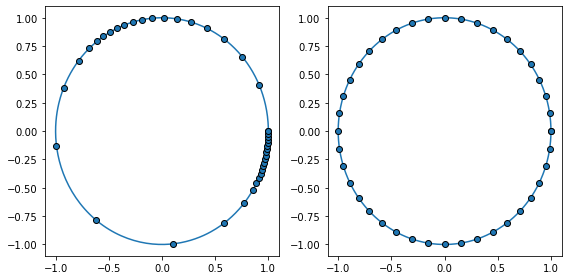

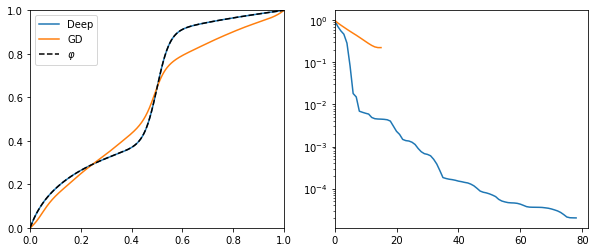

In [6]:
c2 = Circle()
g = LogStepDiff()
c1 = c2.compose(g)
q = SRVT(c1)
r = SRVT(c2)

n = 6  # Number of basis functions in layer
k = 1024  # Number of points used for evaluation.


# Deep reparametrization
loss = CurveDistance(q, r, k=k)
RN = CurveReparametrizer([
    SineSeries(n) for _ in range(6)
])
opt = torch.optim.LBFGS(RN.parameters(), line_search_fn='strong_wolfe', max_iter=300, max_eval=300)
error_deep = reparametrize(RN, loss, opt, 1, Logger(1))
RN.detach()
x = col_linspace(0, 1, k)
y_deep = RN(x)

# Gradient Descent
y_gd, error_gd = gradient_descent(q, r, k, n, verbose=True)

# Plot curves
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_curve(c1, npoints=k, dotpoints=41, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, npoints=k, dotpoints=41, ax=plt.gca())
plt.tight_layout()
plt.show()

# Plot diffeomorphism and subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(x, y_deep, label="Deep")
ax1.plot(x, y_gd, label="GD")
ax1.plot(x, g(x), 'k--', label=r'$ \varphi $')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.legend()
ax2.semilogy(error_deep / error_deep[0])
ax2.semilogy(error_gd / error_gd[0])
ax2.set_xlim(0, None)
plt.show()

## 3. Curve Interpolation

[Iter     1] loss: 9.425828
[Iter     2] loss: 4.488679
[Iter     3] loss: 3.712471
[Iter     4] loss: 2.960023
[Iter     5] loss: 2.769243
[Iter     6] loss: 2.769241
[Iter     7] loss: 2.769241

Finished training in 1.14101s


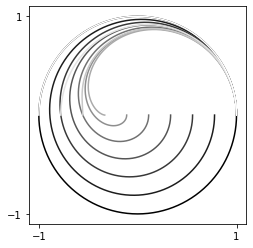

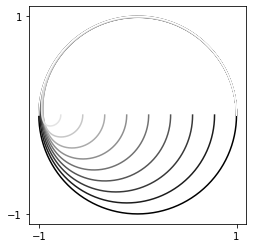

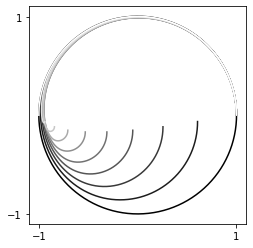

In [46]:
import torch
import torch.optim as optim
from matplotlib import cm

from funcshape.interpolation import linear_interpolate, geodesic
from funcshape.testlib.curves import HalfCircle
from funcshape.visual import create_figsaver

savefig = create_figsaver("../figures/interpolation/")

c1 = Circle()
c2 = HalfCircle()
q = SRVT(c1)
r = SRVT(c2)

RN = CurveReparametrizer([
    SineSeries(10) for i in range(4)
])

# Define loss function
loss_func = CurveDistance(q, r, k=2048)
optimizer = optim.LBFGS(RN.parameters(), lr=1, max_iter=100, line_search_fn='strong_wolfe')
error = reparametrize(RN, loss_func, optimizer, 300, Logger(1))

# Get plot data to visualize diffeomorphism
RN.detach()
x = col_linspace(0, 1, 1024)
y = RN(x)
rafter = r.compose(RN)

# Interpolate
numsteps=10
curves = linear_interpolate(c1, c2, steps=numsteps)
curves_after = linear_interpolate(c1, c2.compose(RN), steps=numsteps)
srvts = geodesic(q, rafter, steps=numsteps)
colors = cm.get_cmap("gray")(np.linspace(0,1,numsteps))

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
[plot_curve(ci, ax=ax1, color=colori, npoints=601) for ci, colori in zip(curves, colors)]
ax1.set_aspect("equal")
ax1.set_xticks([-1, 1])
ax1.set_yticks([-1, 1])
savefig("linear.pdf")


fig, ax2 = plt.subplots(1, 1, figsize=(4, 4))
[plot_curve(ci, ax=ax2, color=colori, npoints=601) for ci, colori in zip(curves_after, colors)]
ax2.set_aspect("equal")
ax2.set_xticks([-1, 1])
ax2.set_yticks([-1, 1])
savefig("reparametrized_linear.pdf")


fig, ax3 = plt.subplots(1, 1, figsize=(4, 4))
start = torch.tensor([1., 0.])
[plot_curve(lambda x: ci(x) + start, ax=ax3, color=colori, npoints=601) for ci, colori in zip(srvts, colors)]
ax3.set_aspect("equal")
ax3.set_xticks([-1, 1])
ax3.set_yticks([-1, 1])
savefig("geodesic.pdf")

plt.show()